In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

In [7]:
def get_available_device() -> str:
    """Returns the device based on the system configuration."""
    if torch.cuda.is_available():
        return torch.device('cuda').type
    if torch.backends.mps.is_available():
        return torch.device('mps').type  # https://pytorch.org/docs/stable/notes/mps.html
    return torch.device('cpu').type

device = get_available_device()
print(f"Using device: {device}")

Using device: cuda


In [8]:
DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[torch.tensor, torch.tensor]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = torch.tensor(x.values, dtype=torch.float32)
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = torch.tensor(y.astype(int).values, dtype=torch.long)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [24]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    """A Multilayer Perceptron (MLP) model in PyTorch with one hidden layer."""

    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(INPUT_SIZE, 100)
        self.output = nn.Linear(100, OUTPUT_SIZE)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: Input tensor.

        Returns:
            Tensor after passing through the layers and activations.
        """
        x = self.relu(self.hidden(x))
        return self.softmax(self.output(x))

learning_rate = 0.01
epochs = 15
batch_size = 32

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

dataset = TensorDataset(x_train, y_train)
# not shuffling so that is more similar to numpy implementation
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = MLP()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []
val_losses = []

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            losses.append(loss.item())
            # calculate validation loss
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
            print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}, validation loss {round(val_loss.item(), 3)}")  # noqa
print(f"Epoch {epoch}, Batch {i:04}, training loss {round(loss.item(), 3)}, validation loss {round(val_loss.item(), 3)}")  # noqa

Epoch 0, Batch 0000, training loss 2.304, validation loss 2.303
Epoch 0, Batch 0200, training loss 2.299, validation loss 2.3
Epoch 0, Batch 0400, training loss 2.295, validation loss 2.295
Epoch 0, Batch 0600, training loss 2.289, validation loss 2.29
Epoch 0, Batch 0800, training loss 2.281, validation loss 2.281
Epoch 0, Batch 1000, training loss 2.26, validation loss 2.266
Epoch 0, Batch 1200, training loss 2.273, validation loss 2.246
Epoch 0, Batch 1400, training loss 2.279, validation loss 2.228
Epoch 0, Batch 1600, training loss 2.163, validation loss 2.209
Epoch 1, Batch 0000, training loss 2.207, validation loss 2.191
Epoch 1, Batch 0200, training loss 2.128, validation loss 2.161
Epoch 1, Batch 0400, training loss 2.08, validation loss 2.125
Epoch 1, Batch 0600, training loss 2.048, validation loss 2.082
Epoch 1, Batch 0800, training loss 2.013, validation loss 2.038
Epoch 1, Batch 1000, training loss 1.902, validation loss 2.001
Epoch 1, Batch 1200, training loss 2.03, vali

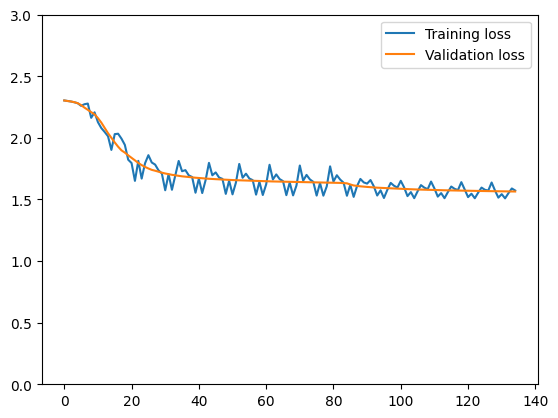

In [26]:
# plot losses over time
plt.plot(losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.ylim(0, 3)
plt.legend()

In [13]:
x_test = x_test.to(device)
y_test = y_test.to(device)

# test the model
with torch.no_grad():
    outputs = model(x_test)
    loss = criterion(outputs, y_test)
    print(f"Test loss: {loss}")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f"Test accuracy: {accuracy:.2f}")

Test loss: 1.631219506263733
Test accuracy: 0.84


Text(0.5, 1.0, 'Count of Misclassified Samples by Class')

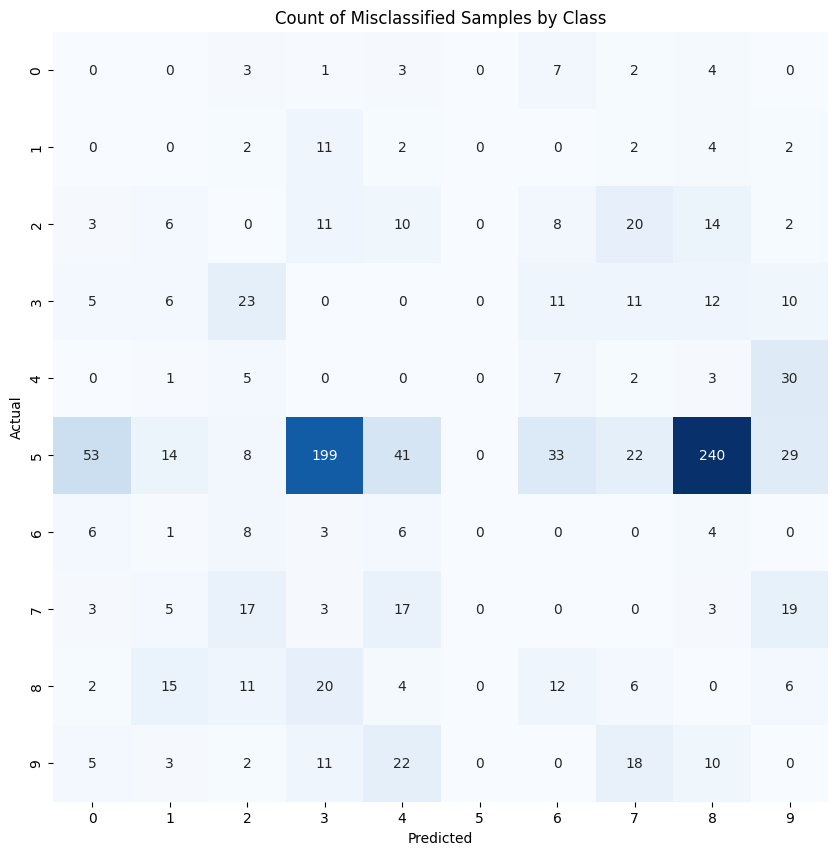

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.cpu(), predicted.cpu())
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')